# Converting Dataframes to PyTrees

Numpyro models expect data in the form of a `pytrees`: nested lists or dictionaries of multidimensional arrays. But datasets usually don't start that way: we usually start by processing them as a `DataFrame`. How do we convert one representation to another?

Let's make this more concrete. Consider the following dataset:

In [1]:
import numpyro
numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro import handlers
import pandas as pd
import numpy as np
import pyro_util
import arviz as az

In [2]:
df = pd.DataFrame({'a': [1,2,1,2,1], 'b': [0,0,1,1,2], 'c': np.random.randn(5), 'd': np.random.randn(5)})

In [3]:
df

,a,b,c,d
0,1,0,0.270611,-0.398499
1,2,0,0.021703,1.137016
2,1,1,-1.224725,0.647109
3,2,1,-1.138450,-0.481904
4,1,2,0.306106,0.516288


Let's say we assume that there's a different latent mean for each value of $a$. We might write the following plated model:

In [25]:
def model(c, d, mask):
    with numpyro.plate("a", 2):
        means = numpyro.sample("mu", dist.Normal(0, 10))
        with numpyro.plate("b", 3):
            numpyro.sample("c", dist.Normal(means, 1), obs=c, obs_mask=mask)
            numpyro.sample("d", dist.Normal(means, 1), obs=d, obs_mask=mask)

But we don't have the `c`, `d`, and `mask` tensors needed for this model yet. We have to convert the dataframe into the appropriate pair of multidimensional arrays. 

First, we can group the dataframe by the plate names.

In [26]:
cols = ['c', 'd']

In [27]:
plates = ['a', 'b']

In [28]:
grouped = df.groupby(plates)[cols].first()

Next, we have to add `NaN` entries to the dataframe to give it a full rectangular shape.

In [29]:
gdf = grouped.reindex(index=pd.MultiIndex.from_product(grouped.index.levels))

In [30]:
gdf

c         d
a b                    
1 0  0.270611 -0.398499
  1 -1.224725  0.647109
  2  0.306106  0.516288
2 0  0.021703  1.137016
  1 -1.138450 -0.481904
  2       NaN       NaN

Now, we can reshape the dataframe's values into a multidimensional array. 

In [31]:
reshaped = np.reshape(gdf.values, (*gdf.index.levshape, len(cols)))

Finally, we can split the array into the two columns we need. 

In [32]:
list(reshaped.transpose())

[array([[ 0.27061132,  0.02170263],
        [-1.22472478, -1.13844963],
        [ 0.30610565,         nan]]),
 array([[-0.39849915,  1.13701604],
        [ 0.6471092 , -0.48190389],
        [ 0.5162882 ,         nan]])]

We can generate the `obs_mask` for numpyro by checking for nan values. Together, this gives us the following function:

In [40]:
def to_pytree(df, cols, groups):
    grouped = df.groupby(groups)[cols].first()
    gdf = grouped.reindex(index=pd.MultiIndex.from_product(grouped.index.levels))
    reshaped = np.reshape(gdf.values, (*gdf.index.levshape, len(cols)))
    results = list(reshaped.transpose())
    results.append(~np.isnan(results[0]))
    return results

Using it looks like this:

In [41]:
mcmc = pyro_util.fit_nuts(model, *to_pytree(df, cols, plates))

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [46]:
result = az.from_numpyro(mcmc)

As expected, the posterior values of `mu` center around zero.

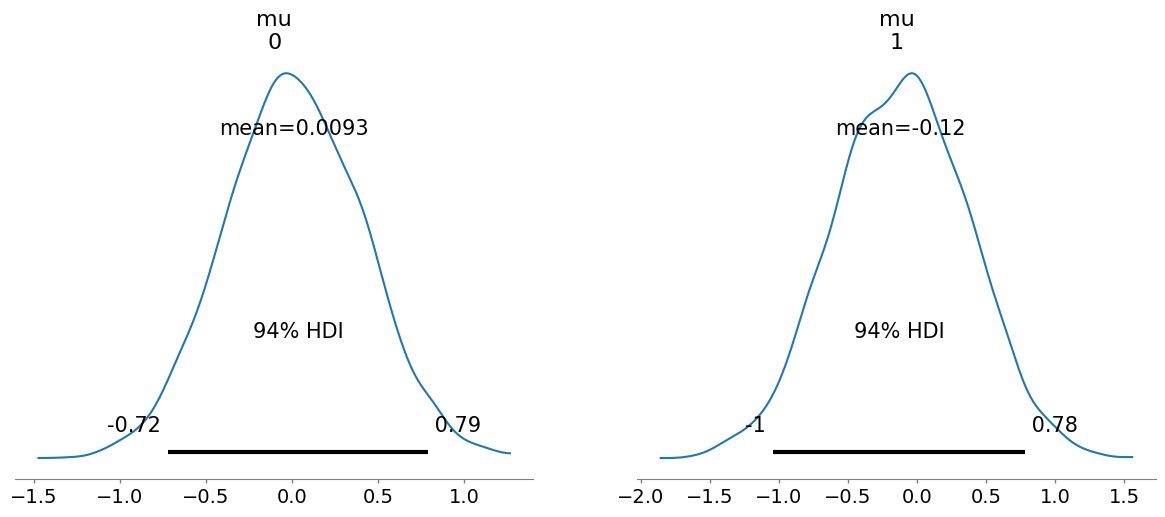

In [52]:
az.plot_posterior(result, var_names=['mu']);

For future posts, I'll be importing this `to_pytree` function from my `pyro_util` module. 